In [1]:
import os
os.chdir('/media/user/T7 Touch/PhD_Lucas/rna_sequencing/')

import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import torch
import otscomics
import matplotlib.pyplot as plt

sc.settings.verbosity = 3 # errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

2024-02-01 20:56:54.468867: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-01 20:56:54.468893: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-01 20:56:54.469568: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-01 20:56:54.473815: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-01 20:56:55.182235: W tensorflow/compiler/tf2

scanpy==1.9.8 anndata==0.10.5.post1 umap==0.5.5 numpy==1.26.3 scipy==1.12.0 pandas==2.0.3 scikit-learn==1.4.0 statsmodels==0.14.1 pynndescent==0.5.11


In [4]:
df = pd.read_csv('/media/user/T7 Touch/PhD_Lucas/rna_sequencing/data/external/momix_rna_preprocessed.csv', index_col=0)

In [8]:
df.sum(0)

Cell_1_HCT       47237.112108
Cell_2_HCT       47882.653898
Cell_3_HCT       51737.914561
Cell_4_HCT       42287.938164
Cell_5_HCT       52220.707984
                     ...     
Cell_202_K562    25807.477633
Cell_203_K562    33849.452409
Cell_204_K562    33764.189533
Cell_205_K562    36419.184066
Cell_206_K562    29984.337328
Length: 206, dtype: float64

In [50]:
adata = sc.read_h5ad("models/adata.h5ad")

In [51]:
sc.pp.filter_cells(adata, min_genes=400)
sc.pp.filter_genes(adata, min_cells=3)

sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
sc.pp.normalize_total(adata, target_sum=1)
sc.pp.log1p(adata)

filtered out 9810 cells that have less than 400 genes expressed
filtered out 15158 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)


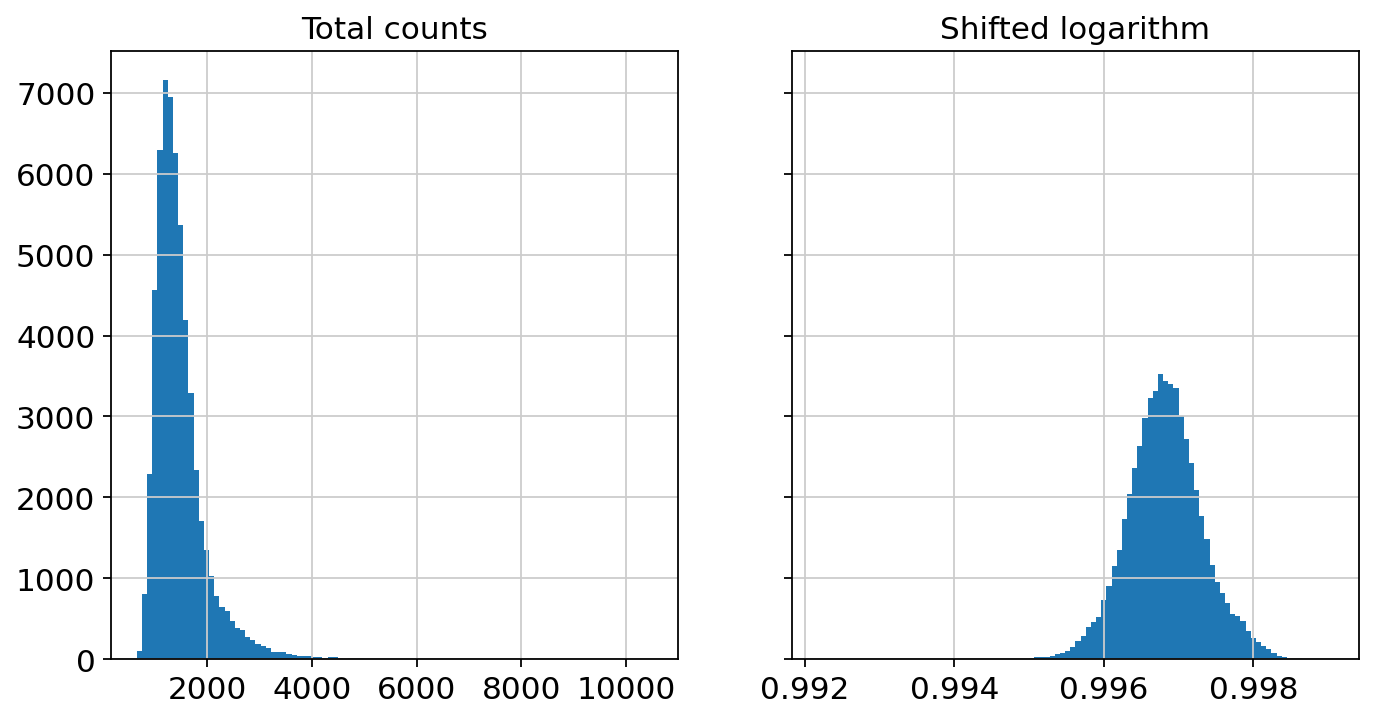

In [52]:
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 5))

ax1.set_title("Total counts")
ax1.hist(adata.obs["total_counts"], bins=100)

ax2.set_title("Shifted logarithm")
ax2.hist(adata.X.sum(1), bins=100)
plt.show()

In [55]:
import scipy.stats as stats

cells_names = adata.obs_names
class_labels = adata.obs['celltype']

# Stratify the data
strata = {}
for label in class_labels.unique():
    strata[label] = cells_names[class_labels == label]

# Calculate sample sizes
strata_sample_sizes = {
    label: int(0.1 * len(stratum)) for label, stratum in strata.items()
}

# Perform stratified sampling
sample_names = np.array([])
for label, stratum in strata.items():
    sample_size = strata_sample_sizes[label]
    sample_names = np.concatenate((sample_names, np.random.choice(stratum, sample_size)))

idxs = np.where(np.isin(adata.obs_names, sample_names))[0]
adataSample = adata[idxs]

In [61]:
adata

AnnData object with n_obs × n_vars = 58769 × 17580
    obs: 'celltype', 'n_genes', 'n_genes_by_counts', 'total_counts'
    var: 'gene_ids', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'

In [87]:
adataFilter2 = adataSample.copy()
stds = np.argsort(np.std(adataFilter2.X.toarray(), 0))  # idx of sorted stds
hv = stds[::-1][:1000]

adataFilter2 = adataFilter2[:, hv]

In [62]:
adataFilter = adataSample.copy()
sc.pp.highly_variable_genes(adataFilter, n_top_genes=1000)
hv = np.where(adataFilter.var['highly_variable'])[0]

adataFilter = adataFilter[:, hv]

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [89]:
clusters = adataFilter2.obs['celltype']                    # get the cell type df
idx = np.argsort(clusters.values)                   # idx of sorted array

print("The 11 labels for cell type classification are:\n")
print(np.unique(clusters))

The 11 labels for cell type classification are:

['CD14+ Monocyte' 'CD19+ B' 'CD34+' 'CD4+ T Helper2' 'CD4+/CD25 T Reg'
 'CD4+/CD45RA+/CD25- Naive T' 'CD4+/CD45RO+ Memory' 'CD56+ NK'
 'CD8+ Cytotoxic T' 'CD8+/CD45RA+ Naive Cytotoxic' 'Dendritic']


In [90]:
from scipy.spatial.distance import cdist

metrics = ['euclidean', 'cityblock', 'cosine', 'correlation']

norm = adataFilter2.X.toarray()

matrices2 = []
for metric in metrics:
    print(metric)
    A = cdist(norm, norm, metric)
    A /= A.max()

    matrices2.append(A)

euclidean
cityblock
cosine
correlation


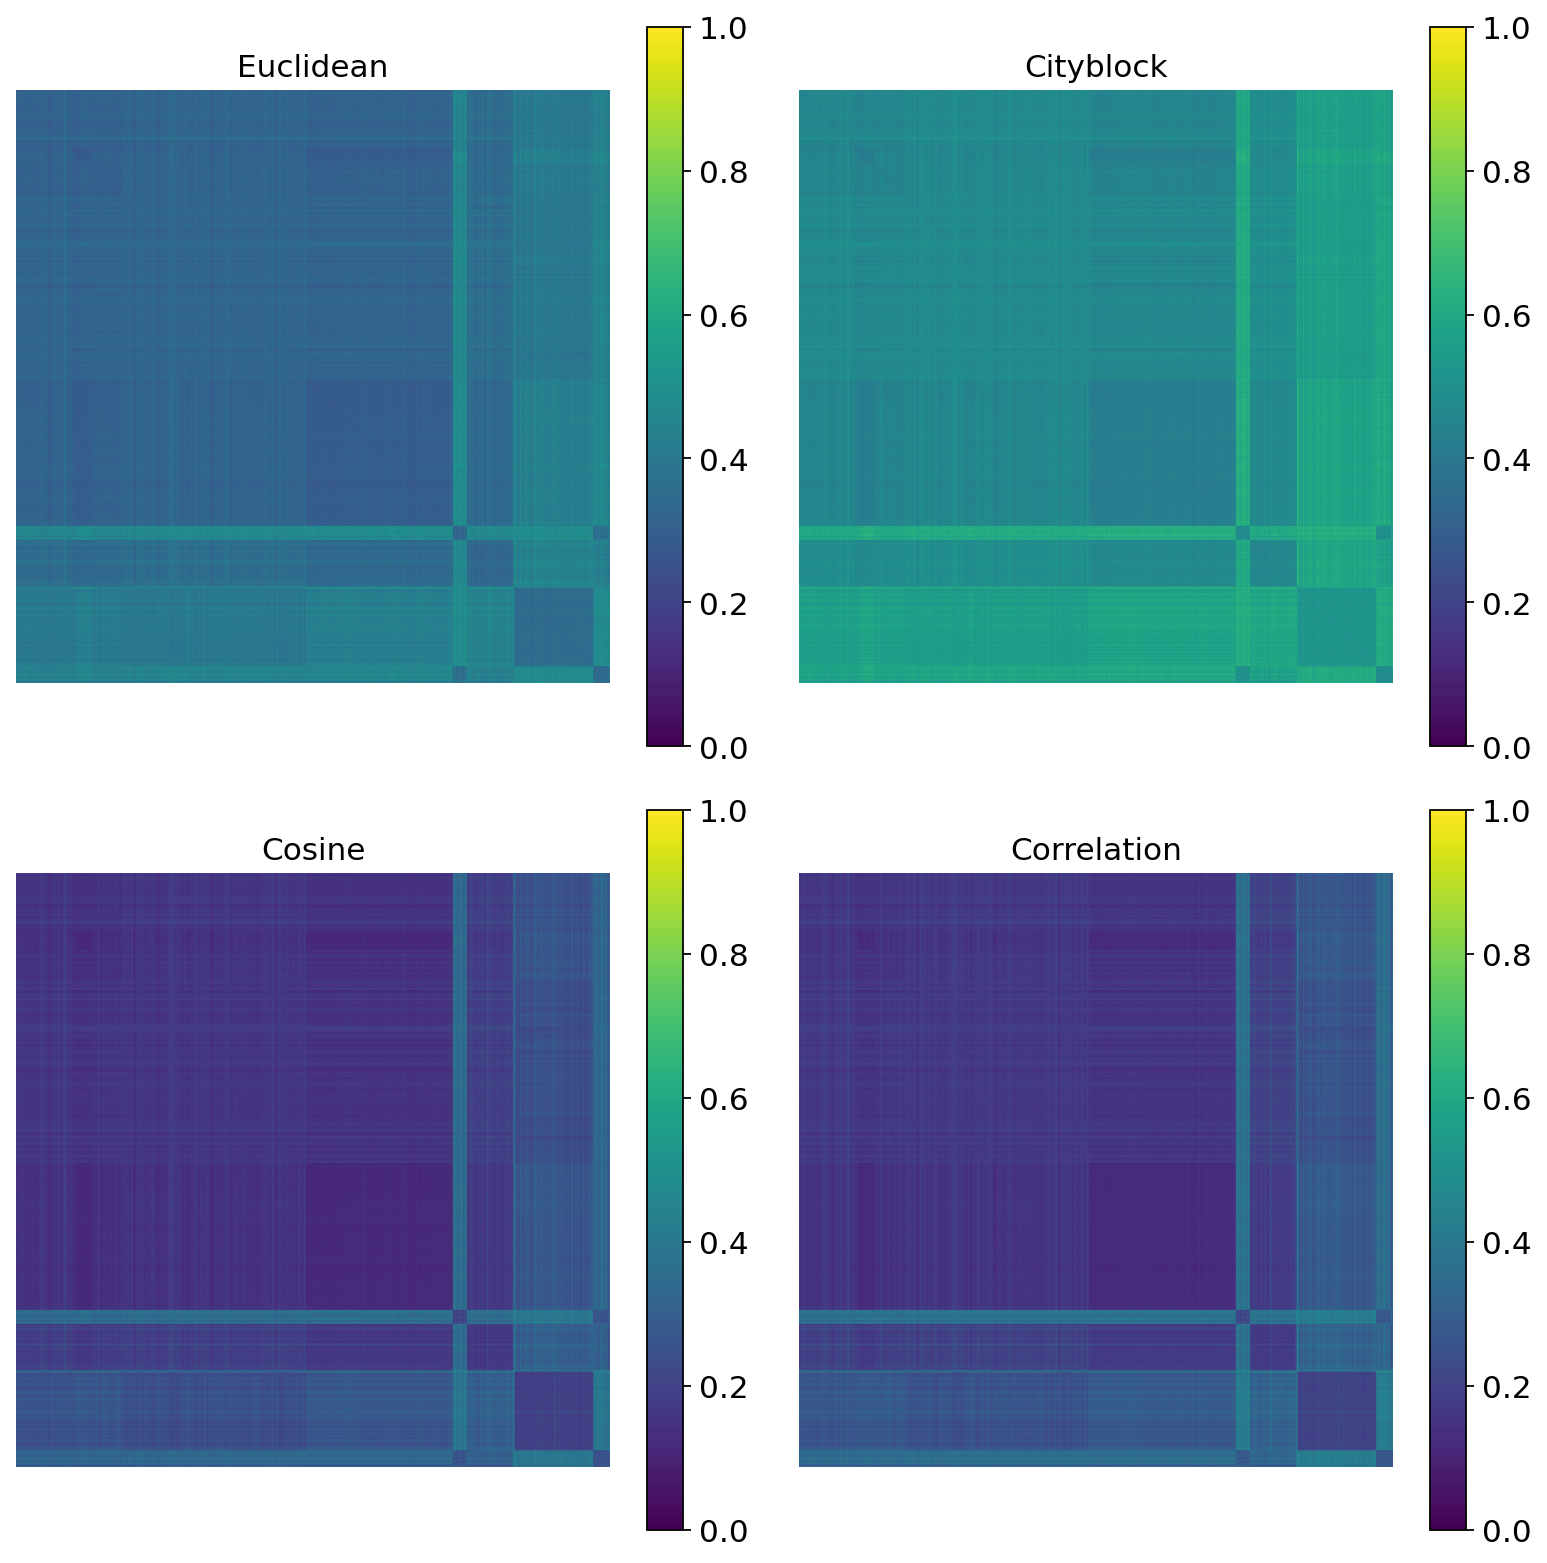

In [91]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

for i, matrix in enumerate(matrices2):
    row, col = i//2, i%2
    im = axes[row, col].imshow(matrix[idx][:,idx])
    axes[row, col].axis('Off')
    axes[row, col].set_title(metrics[i].title())
    fig.colorbar(im)

plt.tight_layout()
plt.show()

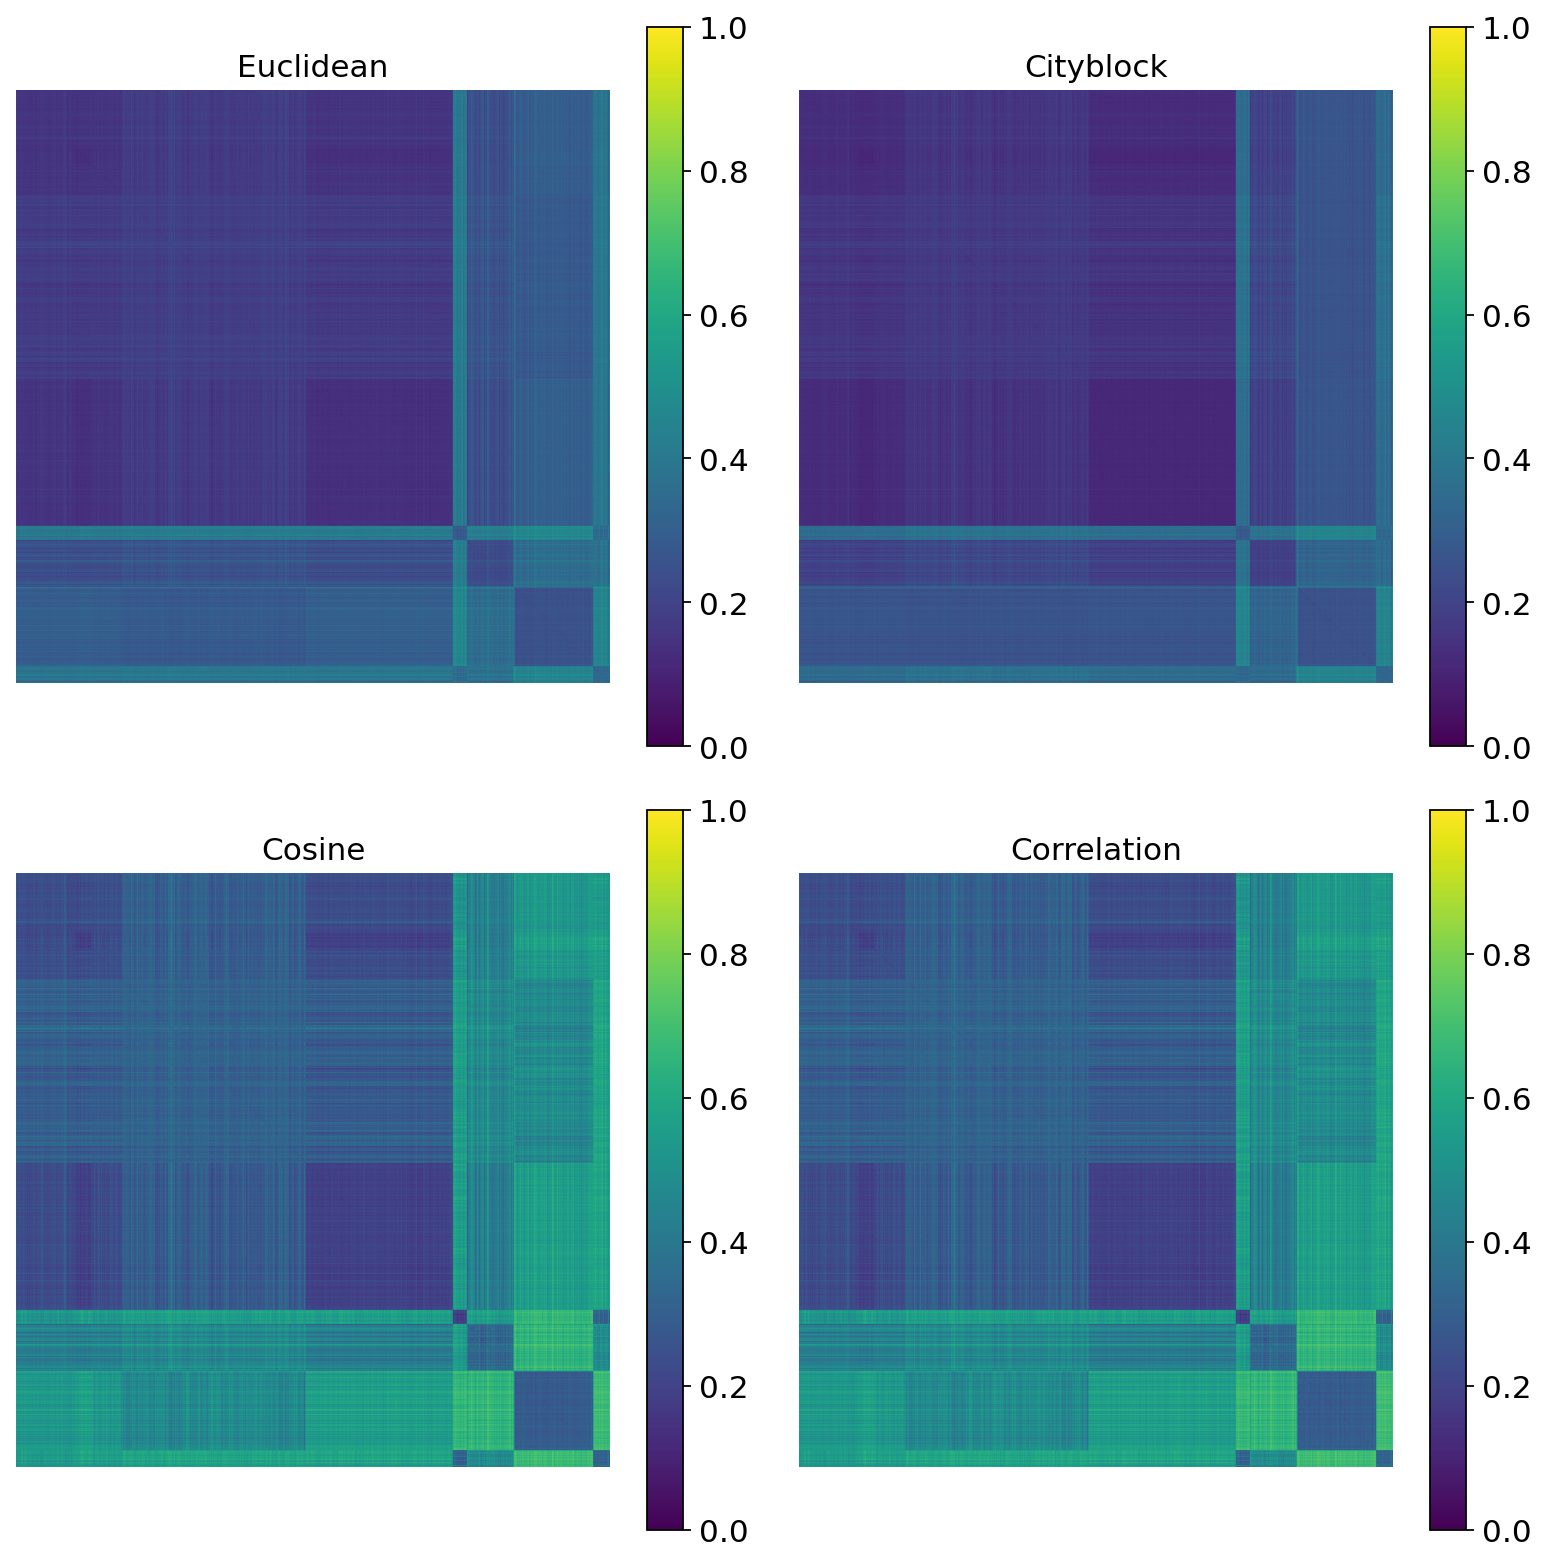

In [86]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

for i, matrix in enumerate(matrices):
    row, col = i//2, i%2
    im = axes[row, col].imshow(matrix[idx][:,idx])
    axes[row, col].axis('Off')
    axes[row, col].set_title(metrics[i].title())
    fig.colorbar(im)

plt.tight_layout()
plt.show()

In [59]:
from scipy.spatial.distance import cdist

norm = adataSample.X.toarray()
# Replace `euclidean` with any scipy distance metric.
D_eu = cdist(norm, norm, metric='euclidean')
D_eu /= D_eu.max()

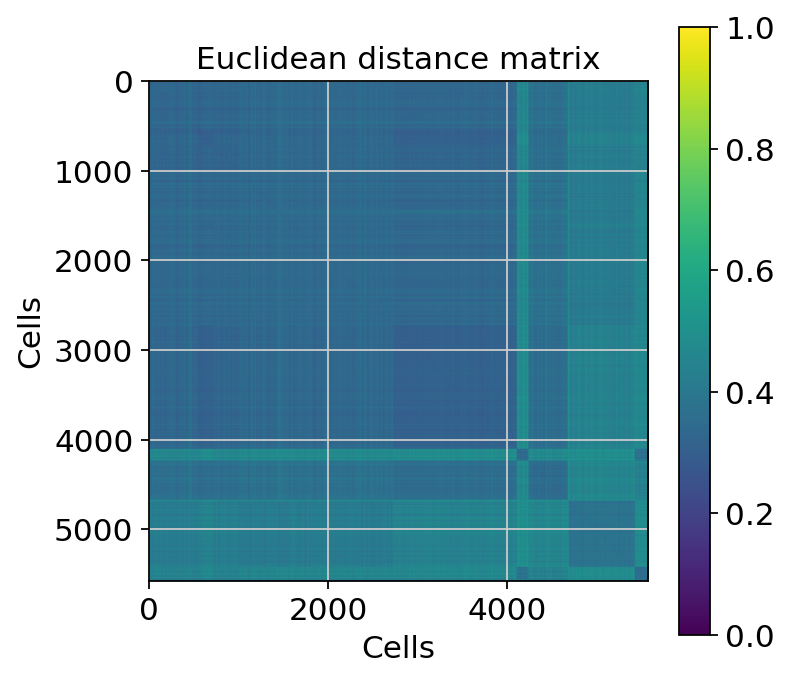

In [60]:
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(D_eu[idx][:,idx])
fig.colorbar(im)
plt.title('Euclidean distance matrix')
plt.xlabel('Cells')
plt.ylabel('Cells')
plt.show()